In [2]:
import pandas as pd
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
from create_datasets.create_table_datasets import adni_data
from ml_models.machine_learning_models import main, baseline_model_custom

**1. Create table datasets**

Create table datasets (with and without APOE) for the targets and genes of interest to use as input for more-standard machine learning models.

In [2]:
infile1 = f'data/ADNI/AD_PPI_missense.csv'
infile2 = 'data/ADNI/ADNIMERGE_metadata.csv'

table_dataset = adni_data('missense', 'data/other_networks/AD_SNAP_PPI_brain.edgelist', infile1, infile2)
table_dataset.to_csv(f'data/table_datasets/AD_PPI_missense_ADNI_labeled.csv')

**2. Run no-GNN models**

Run more-standard machine learning models 3 times (to properly compare with the 3 runs for each GNN model).

In [3]:
baseline_model_custom('PET', 'data/table_datasets/AD_PPI_missense_ADNI_labeled.csv')
baseline_model_custom('PETandDX', 'data/table_datasets/AD_PPI_missense_ADNI_labeled.csv')

In [5]:
main('ADNI', 'AD_SNAP_PPI_brain', 'PET', 'data/table_datasets', f'results/results_missense_PET')
main('ADNI', 'AD_SNAP_PPI_brain', 'PETandDX', 'data/table_datasets', f'results/results_missense_PETandDX')
# result_ad_noAPOE = main('ADNI_noAPOE', 'AD', 'PPI', target, 'data/table_datasets', f'results/results_missense_PET_noAPOE_rep{i}')

Joint results of both baseline, no-GNN, and GNN models are in [results/GNNs_comparison](results/GNNs_comparison/) for [PET](results/GNNs_comparison/2022_01_PET.csv) and [PET&DX](results/GNNs_comparison/2022_01_PETandDX.csv) targets.

Next lines plot these results obtained using ADNI dataset (Figure 2 of the paper).

In [225]:
def statistics(df, baseline):
    pvalues = pd.DataFrame()
    for d in df['Dataset'].unique():
        tmp = df.loc[df['Dataset'] == d]
        for m in ['Random Forest', 'SVM Linear', 'SVM RBF', 'Logistic Regression', 'GNN GraphGym']:
            tmp_model = tmp.loc[tmp['Model'] == m]
            values = tmp_model['AUC'].values
            t1, p1 = stats.ttest_1samp(values, baseline, alternative='greater') # (a, popmean), mean of the underlying distribution of the sample is greater than the given population mean (popmean)
            t2, p2 = stats.ttest_1samp(values, 0.5, alternative='greater') # (a, popmean), mean of the underlying distribution of the sample is greater than the given population mean (popmean)
            
            if p1 < 0.05:
                s1 = '*'
            else:
                s1 = '-'

            if p2 < 0.05:
                s2 = '*'
            else:
                s2 = '-'

            # print(d, m, p1, p2)

            pvalues = pvalues.append([[d, m, p1, s1, p2, s2]])
            
    pvalues.rename(columns={0:'Dataset', 1:'Model', 2:'p-value Baseline', 3:'sigf. Baseline', 4:'p-value Random', 5:'sigf. Random'}, inplace=True)
    return pvalues
    

In [17]:
def barplot_comparision_ml(target, df, metric, title):

    sns.set_style("ticks")
    
    colors = ["#F8766D", "#a3a500", "#00bf7d", "#00b0f6", "#E76BF3"]
    custom = sns.set_palette(sns.color_palette(colors))

    plt.figure(figsize=(8, 8))
    sns.boxplot(x = 'dataset',
                     y = metric,
                     hue = 'model',
                    #  ci = 'sd',
                     data = df,
                     palette = custom)
    # plt.axhline(y=bs, color='r', linestyle='dotted', label=f'Baseline model ({bs})')
    # plt.axhline(y=0.5, color='b', linestyle='dotted', label=f'Random (0.5)')

    plt.legend(fontsize=12, loc='upper center')
    plt.ylim(0.5, 1.0)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel(f'{metric} obtained in test set', fontsize=16)
    plt.title(title, fontsize=16)
    plt.tight_layout()
    
    # plt.savefig(f'figures/figure2{title}.pdf', dpi=500)
    # plt.savefig(f'figures/figure2{title}.png', dpi=500)

In [13]:
from scipy import stats

petdx_results = pd.read_csv('results/2022_03_comparison_PETandDX.csv')


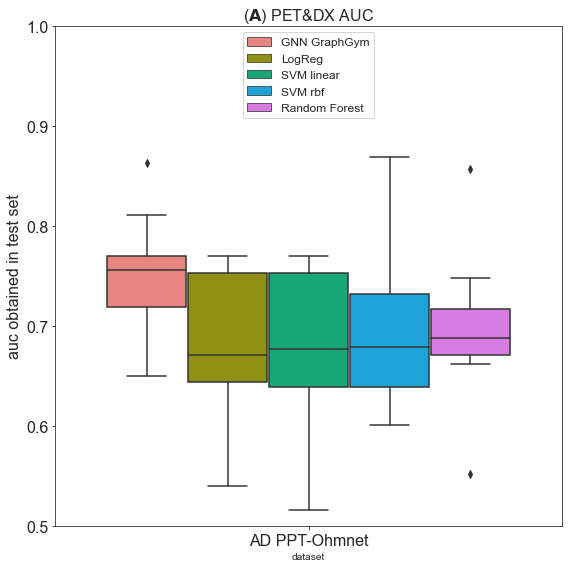

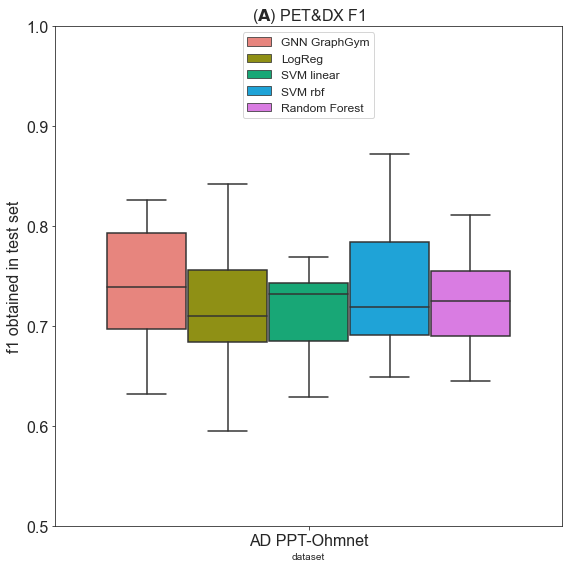

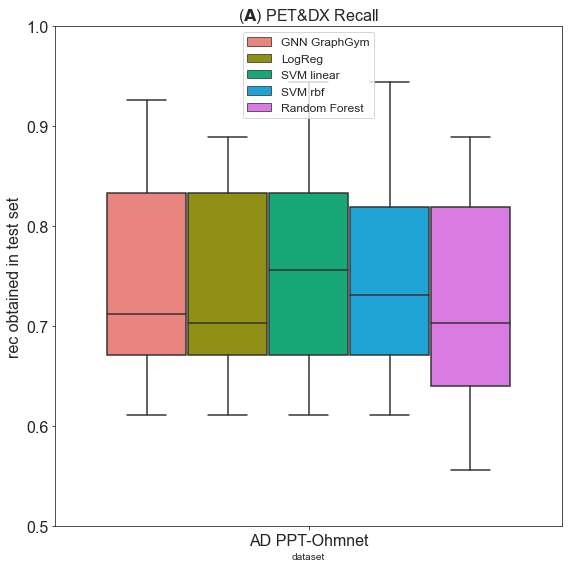

In [22]:
barplot_comparision_ml('PETandDX', petdx_results, 'auc', r"($\bf{A}$) PET&DX AUC")
barplot_comparision_ml('PETandDX', petdx_results, 'f1', r"($\bf{A}$) PET&DX F1")
barplot_comparision_ml('PETandDX', petdx_results, 'rec', r"($\bf{A}$) PET&DX Recall")

In [253]:
petdx_results = pd.read_csv('results/GNNs_comparison/2022_03_PETandDX.csv')
petdx_baseline = petdx_results.iloc[30]
petdx_results.drop([30], inplace=True)
petdx_pvalues = statistics(petdx_results, 0.6825)
petdx_pvalues

,Dataset,Model,p-value Baseline,sigf. Baseline,p-value Random,sigf. Random
0,AD STRING,Random Forest,0.016356,*,0.000935,*
0,AD STRING,SVM Linear,0.998967,-,0.000037,*
0,AD STRING,SVM RBF,0.962577,-,0.000086,*
0,AD STRING,Logistic Regression,1.000000,-,0.000000,*
0,AD STRING,GNN GraphGym,0.099680,-,0.002236,*
0,AD STRING\nNo APOE,Random Forest,0.997332,-,0.049300,*
0,AD STRING\nNo APOE,SVM Linear,0.976788,-,0.746133,-
0,AD STRING\nNo APOE,SVM RBF,0.978437,-,0.719308,-
0,AD STRING\nNo APOE,Logistic Regression,0.998343,-,0.908248,-
0,AD STRING\nNo APOE,GNN GraphGym,0.942137,-,0.371337,-


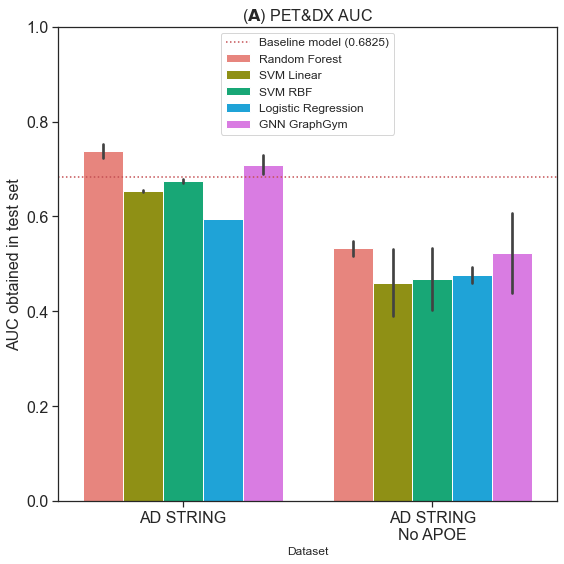

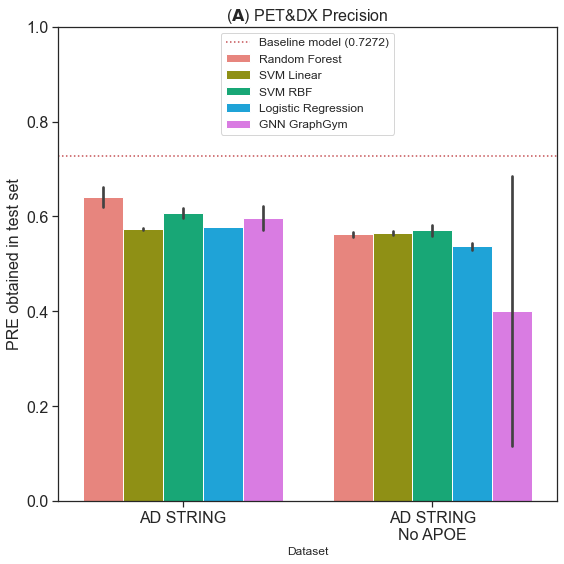

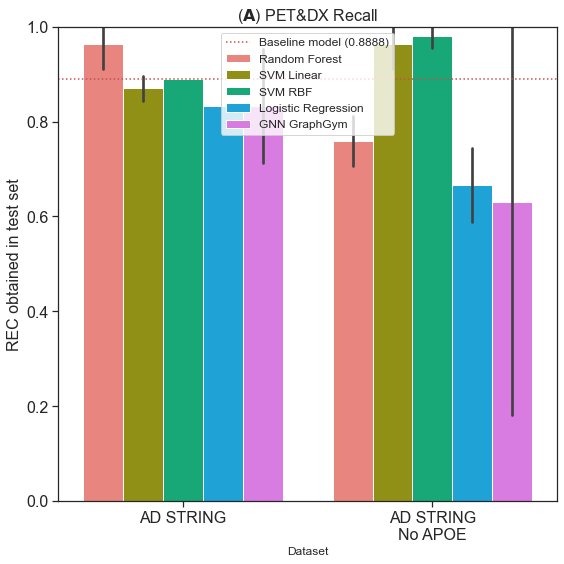

In [254]:
barplot_comparision_ml('PET&DX', petdx_baseline['AUC'], petdx_results, 'AUC', r"($\bf{A}$) PET&DX AUC")
barplot_comparision_ml('PET&DX', petdx_baseline['PRE'], petdx_results, 'PRE', r"($\bf{A}$) PET&DX Precision")
barplot_comparision_ml('PET&DX', petdx_baseline['REC'], petdx_results, 'REC', r"($\bf{A}$) PET&DX Recall")